### Load Libraries

In [1]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/OperationResearchs/clustering_and_discretization/src/"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import logging

##### Configs

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### Load Data
#### A. grid data

In [5]:
grid_df = gpd.read_file("../data/geodf.geojson")

In [6]:
grid_df.head(1)

,cell_id,geometry
0,0,"POLYGON ((-68.17297 -16.60185, -68.16360 -16.6..."


#### B. pixel data

In [7]:
df = pd.read_csv("../data/customers_with_layers_v1.csv")

In [8]:
df.head(1)

,year,month,cod_customer,lat,lon,demand,demand_daily,layer,pixel
0,2020,6,807126,-16.495765,-68.12141,1.0,1,0,197.0


### Description of Layers

In [9]:
from app.plots.plot_grid import Plot_Grid

In [10]:
def plot_by_layer(layer: int, df: pd.DataFrame, geo: gpd.GeoDataFrame, choice = False) -> None:
    """
    """
    df_filtered = df[df.layer == layer].reset_index(drop=True)
    plotter = Plot_Grid(
        grid_geo = geo,
        df = df_filtered,
    )
    logger.info(f"[PLOT-BY-LAYER] Layer {layer} is plotting")
    # n customer per pixel
    if not choice:
        plotter.plot_density_customer()

        # std per pixel
        plotter.plot_grid_by_metric(metric="std")
    
    # mean per pixel
    plotter.plot_grid_by_metric(metric="mean")
    

#### A. Current State

## Aggregation Process

In [11]:
from app.aggregations.pixel import Meta_Pixel, Pixel
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import geopandas as gpd

In [12]:
LAYER_SELECTED = 2

In [13]:
df_used = df[df.layer == LAYER_SELECTED].reset_index(drop=True)
df_used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          3204 non-null   int64  
 1   month         3204 non-null   int64  
 2   cod_customer  3204 non-null   int64  
 3   lat           3204 non-null   float64
 4   lon           3204 non-null   float64
 5   demand        3204 non-null   float64
 6   demand_daily  3204 non-null   int64  
 7   layer         3204 non-null   int64  
 8   pixel         3204 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 225.4 KB


In [14]:
merged_df = grid_df.merge(df_used,
                         left_on="cell_id",
                         right_on="pixel",
                         how="left")
merged_df["demand_daily"] = merged_df["demand_daily"].fillna(0)
merged_df["pixel"] = merged_df.apply(lambda x: x["pixel"] if not x["pixel"] else x["cell_id"], axis=1)
merged_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   cell_id       3426 non-null   int64   
 1   geometry      3426 non-null   geometry
 2   year          3204 non-null   float64 
 3   month         3204 non-null   float64 
 4   cod_customer  3204 non-null   float64 
 5   lat           3204 non-null   float64 
 6   lon           3204 non-null   float64 
 7   demand        3204 non-null   float64 
 8   demand_daily  3426 non-null   float64 
 9   layer         3204 non-null   float64 
 10  pixel         3426 non-null   int64   
dtypes: float64(8), geometry(1), int64(2)
memory usage: 294.5 KB


In [15]:
## Create Pixel Object
pixels = {}
for element in merged_df.to_dict(orient="records"):
    if element["pixel"] in pixels:
        pixels[element['pixel']].add_customer(element)
    else:
        init = {
            "id": element["pixel"],
            "corner_down_left": list(element["geometry"].exterior.coords)[3],
            "corner_down_right": list(element["geometry"].exterior.coords)[2],
            "corner_up_right": list(element["geometry"].exterior.coords)[1],
            "corner_up_left": list(element["geometry"].exterior.coords)[0],
            "demand_daily": element["demand_daily"]
        }
        #logger.info(f"Creating pixel {init}\n")
        pixels[element['pixel']] = Pixel(init)
logger.info(f"Total Pixel object created {len(pixels)}")

INFO:__main__:Total Pixel object created 304


In [16]:
## Logging descriptive metrics
for k, p in pixels.items():
    avg_demand = p.get_avg_demand()
    std_demand = p.get_std_demand()
    n_customers = p.get_n_customers()
    logger.info(
        f"PIXEL - {k}: avg_demand: {avg_demand:.2f} - std_demand: {std_demand:.2f} - n_customers: {n_customers}"
    )

INFO:__main__:PIXEL - 0: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 1: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 2: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 3: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 4: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 5: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 6: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 7: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 8: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 9: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 10: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 11: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 12: avg_demand: 0.00 - std_demand: 0.00 

INFO:__main__:PIXEL - 104: avg_demand: 16.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 105: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 106: avg_demand: 21.20 - std_demand: 5.11 - n_customers: 5
INFO:__main__:PIXEL - 107: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 108: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 109: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 110: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 111: avg_demand: 16.00 - std_demand: 1.00 - n_customers: 2
INFO:__main__:PIXEL - 112: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 113: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 114: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 115: avg_demand: 23.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 116: avg_deman

INFO:__main__:PIXEL - 205: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 206: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 207: avg_demand: 0.00 - std_demand: 0.00 - n_customers: 0
INFO:__main__:PIXEL - 208: avg_demand: 25.76 - std_demand: 8.95 - n_customers: 74
INFO:__main__:PIXEL - 209: avg_demand: 23.89 - std_demand: 8.46 - n_customers: 38
INFO:__main__:PIXEL - 210: avg_demand: 29.62 - std_demand: 10.02 - n_customers: 73
INFO:__main__:PIXEL - 211: avg_demand: 29.38 - std_demand: 11.49 - n_customers: 91
INFO:__main__:PIXEL - 212: avg_demand: 18.00 - std_demand: 3.00 - n_customers: 4
INFO:__main__:PIXEL - 213: avg_demand: 21.51 - std_demand: 7.55 - n_customers: 45
INFO:__main__:PIXEL - 214: avg_demand: 25.36 - std_demand: 8.90 - n_customers: 25
INFO:__main__:PIXEL - 215: avg_demand: 15.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 216: avg_demand: 16.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 2

In [17]:
def plot_pixels(pixels: list[Pixel], metric: str):
    polygons = []
    demands = []
    std = []
    n_customers = []
    ids = []

    for pixel in pixels:
        polygon = pixel.get_polygon()
        demand = pixel.get_avg_demand()
        std_ = pixel.get_std_demand()
        n_customer = pixel.get_n_customers()
        polygons.append(polygon)
        demands.append(demand)
        std.append(std_)
        n_customers.append(n_customer)
        ids.append(pixel.id)

    data = {"geometry": polygons,
            "demand": demands,
            "std": std,
            "n_customer": n_customers,
            "id": ids,}
    gdf = gpd.GeoDataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    if metric != "id":
        gdf[gdf[metric] == 0].boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")

        gdf[gdf[metric] > 0].plot(
            ax=ax,
            column=metric,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )
    else:
        gdf[gdf["demand"] > 0].plot(
            ax=ax,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )

    for idx, row in gdf[gdf[metric] > 0].iterrows():
        ax.annotate(
            text=round(row[metric],1),
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            ha="center",
            fontsize=8,
        )

    plt.title(f"Plot about {metric} ")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


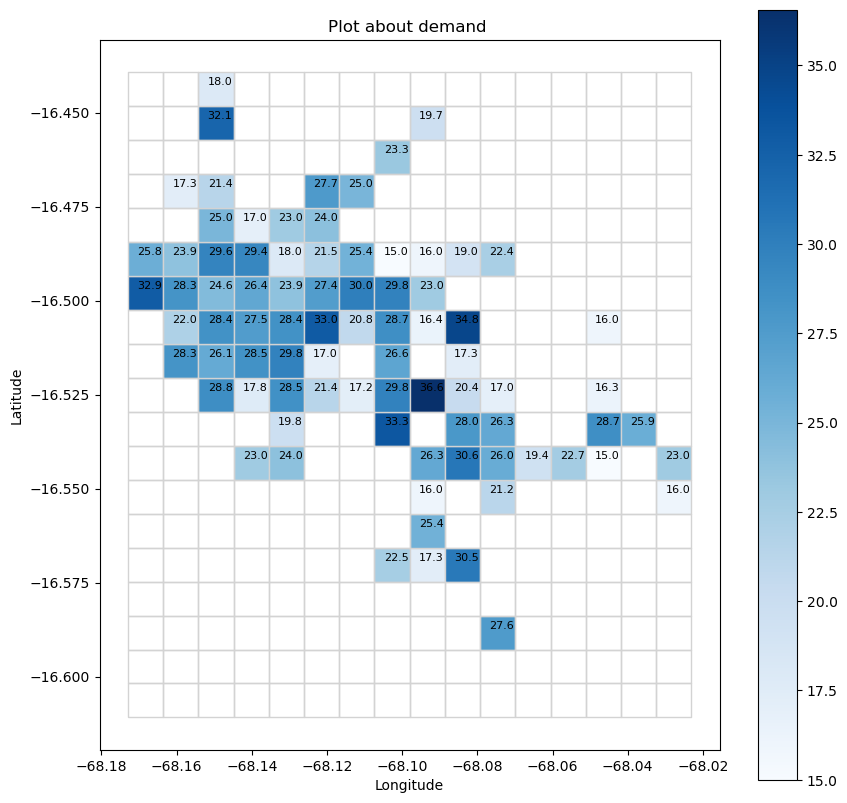

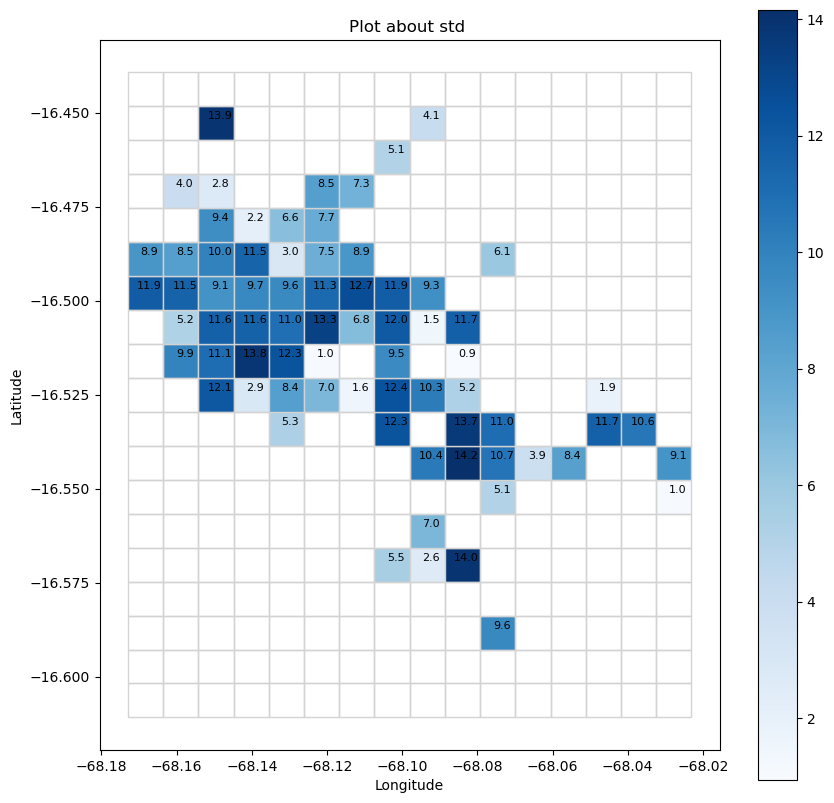

In [18]:
plot_pixels(pixels.values(), 'demand')
plot_pixels(pixels.values(), 'std')


In [19]:
## heuristic
# 1 step: set pixel adjacent - nxn
delta = 0.00000001

for pixel in pixels.values():
    for pixel_adjacent in pixels.values():
        if(pixel.get_polygon().intersects(pixel_adjacent.get_polygon().buffer(delta))):
            pixel.add_pixel_adjacent(pixel_adjacent)

In [20]:
pixels[142].__dict__

{'id': 142,
 'corner_down_left': (-68.04177524445585, -16.53859299696567),
 'corner_down_right': (-68.0324038862027, -16.53859299696567),
 'corner_up_right': (-68.0324038862027, -16.529556710817907),
 'corner_up_left': (-68.04177524445585, -16.529556710817907),
 'demand': [15.0,
  15.0,
  15.0,
  15.0,
  15.0,
  16.0,
  16.0,
  16.0,
  16.0,
  17.0,
  17.0,
  17.0,
  17.0,
  18.0,
  18.0,
  19.0,
  20.0,
  20.0,
  20.0,
  20.0,
  22.0,
  22.0,
  23.0,
  24.0,
  24.0,
  24.0,
  24.0,
  24.0,
  25.0,
  26.0,
  26.0,
  27.0,
  27.0,
  28.0,
  28.0,
  29.0,
  30.0,
  30.0,
  33.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  40.0,
  49.0,
  52.0,
  56.0,
  57.0],
 'pixels_adyacent': [<app.aggregations.pixel.Pixel at 0x137449240>,
 'belong_meta_pixel': False}

In [21]:
meta_pixels = []
pixel_visited = []

# 2 step: per pixel evaluate criterions
for pixel_selected in pixels.values():
    if pixel_selected.belong_meta_pixel == False and pixel_selected.get_n_customers() > 0:
        
        if pixel_selected.get_n_customers() >= 20:
            new = Meta_Pixel(pixel_selected)
            meta_pixels.append(new)
            pixel_selected.belong_meta_pixel = True
            logger.info(
                f"[META] {new.id} created"
            )
    
        else:
            std_pixel_selected = pixel_selected.get_std_demand()
            n_pixel_selected = pixel_selected.get_n_customers()
            
            new_meta_pixel = Meta_Pixel(pixel_selected)
            new_meta_pixel.merge_demand()
            
            std_inicial = new_meta_pixel.get_std_demand()
            n_inicial = new_meta_pixel.get_n_customers()
            
            for pixel_adj in pixel_selected.pixels_adyacent:
                if(pixel_adj.belong_meta_pixel == False):

                    demand_adj = pixel_adj.demand
                    n_adj = pixel_adj.get_n_customers()
                    std_candidate = np.std(demand_adj+new_meta_pixel.demand)

                    if((n_pixel_selected + n_adj >= 20) or (std_candidate <= new_meta_pixel.get_std_demand())):
                        new_meta_pixel.add_pixel(pixel_adj)
                        new_meta_pixel.merge_demand()

            if(new_meta_pixel.get_n_customers() >= 20):
                new_meta_pixel.set_all_belong()
                meta_pixels.append(new_meta_pixel)
                
                logger.info(
                    f"[META] {new_meta_pixel.id}  - std inicial: {std_inicial:.2f} - std final: {new_meta_pixel.get_std_demand():.2f}"
                )
                logger.info(
                    f" n inicial: {n_inicial} - n final: {new_meta_pixel.get_n_customers()}"
                )
            elif pixel_selected.belong_meta_pixel == False:
                logger.info(
                    f"[PIXEL] {pixel_selected.id} is skiped .."
                )
                pixel_visited.append(pixel_selected)
                

for meta in meta_pixels:
    logger.info(f"construct meta pixel {meta.id}")
    meta.construct_meta_pixel()

logger.info(f"[PIXEL VISITED] starting...\n\n\n")
for pixel_selected in pixel_visited:
    delta = 0.000001
    list_candidate = pixel_visited + meta_pixels
    for decrease in [i for i in range(1,100,10)]:
        delta = delta * decrease
        for candidate in list_candidate:
            if(candidate.get_polygon().intersects(pixel_selected.get_polygon().buffer(delta)) and pixel_selected.belong_meta_pixel==False):
                if isinstance(candidate, Meta_Pixel):
                    std_inicial = candidate.get_std_demand()
                    n_inicial = candidate.get_n_customers()
                    
                    std_candidate = np.std(pixel_selected.demand + candidate.demand)
                    if(std_candidate <= candidate.get_std_demand()):
                        candidate.add_pixel(pixel_selected)
                        candidate.merge_demand()
                        candidate.set_all_belong()
                        logger.info(f"[MERGED] pixel {pixel_selected.id} added into meta pixel {candidate.id}")
                        logger.info(
                            f"[] {candidate.id}  - std inicial: {std_inicial:.2f} - std final: {candidate.get_std_demand():.2f}"
                        )
                        logger.info(
                            f" n inicial: {n_inicial} - n final: {candidate.get_n_customers()}"
                        )
                else:
                    pass


INFO:__main__:[META] 42 created
INFO:__main__:[META] 71  - std inicial: 5.50 - std final: 6.77
INFO:__main__: n inicial: 2 - n final: 38
INFO:__main__:[META] 73 created
INFO:__main__:[META] 104  - std inicial: 0.00 - std final: 13.20
INFO:__main__: n inicial: 1 - n final: 92
INFO:__main__:[META] 106  - std inicial: 5.11 - std final: 9.95
INFO:__main__: n inicial: 5 - n final: 108
INFO:__main__:[META] 111  - std inicial: 1.00 - std final: 9.01
INFO:__main__: n inicial: 2 - n final: 49
INFO:__main__:[PIXEL] 115 is skiped ..
INFO:__main__:[PIXEL] 116 is skiped ..
INFO:__main__:[META] 124 created
INFO:__main__:[META] 125  - std inicial: 0.00 - std final: 11.30
INFO:__main__: n inicial: 1 - n final: 110
INFO:__main__:[META] 132  - std inicial: 5.31 - std final: 8.26
INFO:__main__: n inicial: 5 - n final: 61
INFO:__main__:[META] 135 created
INFO:__main__:[META] 137 created
INFO:__main__:[META] 138 created
INFO:__main__:[META] 146 created
INFO:__main__:[META] 150  - std inicial: 1.60 - std fi

In [22]:
for meta in meta_pixels:
    logger.info(f"construct meta pixel {meta.id}")
    meta.construct_meta_pixel()

INFO:__main__:construct meta pixel 42
INFO:__main__:construct meta pixel 71
INFO:__main__:construct meta pixel 73
INFO:__main__:construct meta pixel 104
INFO:__main__:construct meta pixel 106
INFO:__main__:construct meta pixel 111
INFO:__main__:construct meta pixel 124
INFO:__main__:construct meta pixel 125
INFO:__main__:construct meta pixel 132
INFO:__main__:construct meta pixel 135
INFO:__main__:construct meta pixel 137
INFO:__main__:construct meta pixel 138
INFO:__main__:construct meta pixel 146
INFO:__main__:construct meta pixel 150
INFO:__main__:construct meta pixel 152
INFO:__main__:construct meta pixel 161
INFO:__main__:construct meta pixel 163
INFO:__main__:construct meta pixel 164
INFO:__main__:construct meta pixel 169
INFO:__main__:construct meta pixel 179
INFO:__main__:construct meta pixel 180
INFO:__main__:construct meta pixel 181
INFO:__main__:construct meta pixel 182
INFO:__main__:construct meta pixel 183
INFO:__main__:construct meta pixel 184
INFO:__main__:construct meta

In [23]:
def plot_meta_pixels(pixels: list[Pixel], meta_pixels: list[Meta_Pixel], metric: str):
    polygons = []
    demands = []
    std = []
    n_customers = []

    for pixel in pixels:
        polygons.append(pixel.get_polygon())

    data = {"geometry": polygons}
    gdf = gpd.GeoDataFrame(data)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    #gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")

    polygons = []
    for meta in meta_pixels:
        for pixel in meta.pixels:
            polygon = pixel.get_polygon()
            
            demand = meta.get_avg_demand()
            std_ = meta.get_std_demand()
            n_customer = meta.get_n_customers()
            
            polygons.append(polygon)
            demands.append(demand)
            std.append(std_)
            n_customers.append(n_customer)

    data = {"geometry": polygons,
            "demand": demands,
            "std": std,
            "n_customer": n_customers,}
    gdf = gpd.GeoDataFrame(data)
    
    gdf.plot(
        ax=ax,
        column=metric,
        cmap="Blues",  
        linewidth=1,
        edgecolor="lightgrey",
        legend=True,
    )

    for idx, row in gdf.iterrows():
        ax.annotate(
            text=round(row[metric],1),
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            ha="center",
            fontsize=8,
        )

    plt.title(f"Plot about {metric} ")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


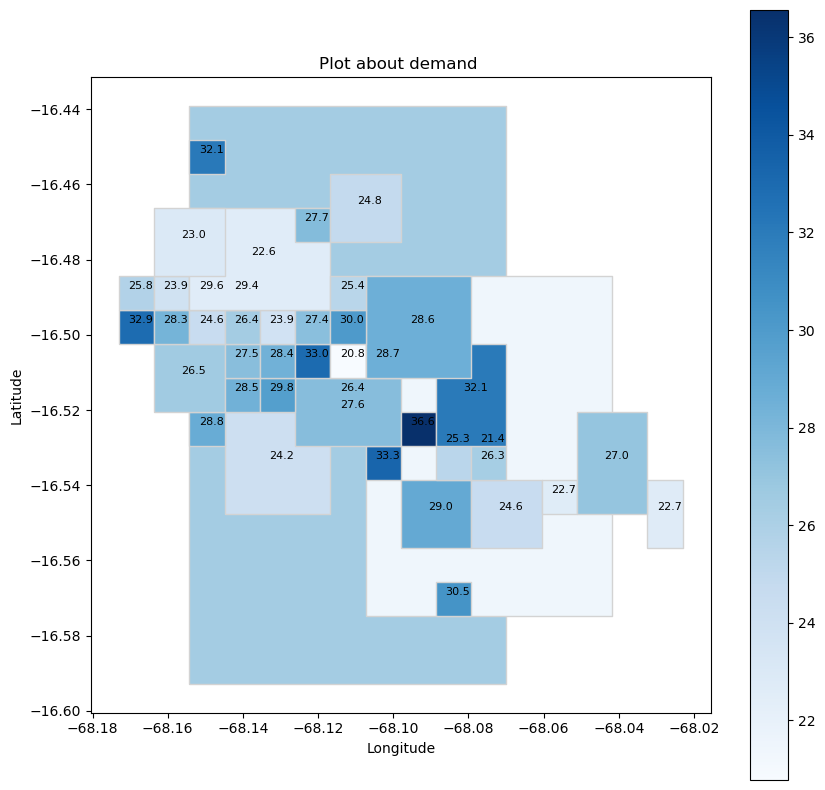

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


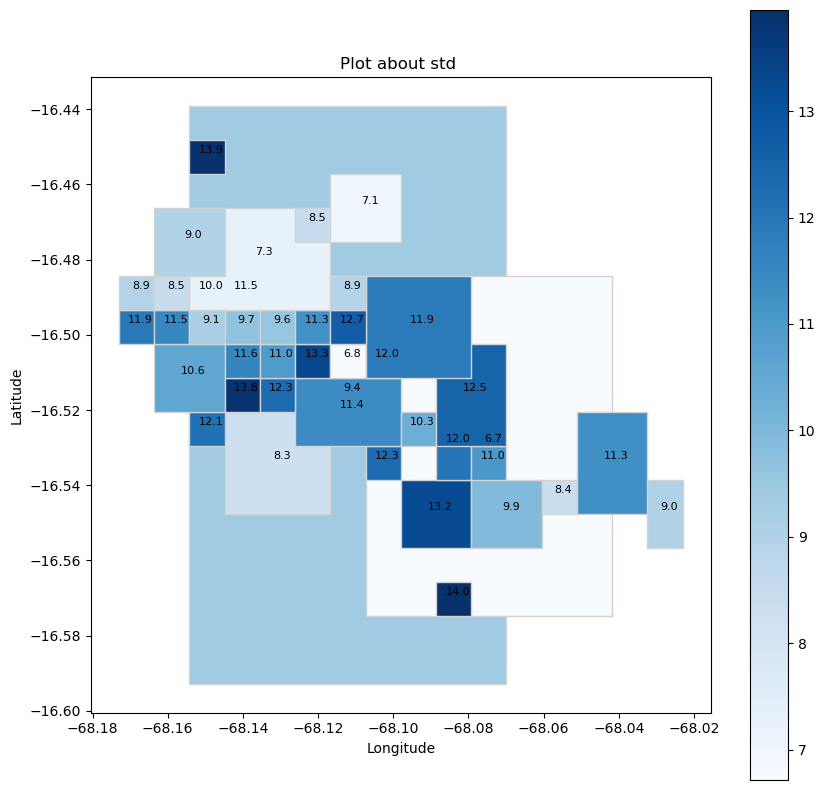

In [24]:
plot_pixels(meta_pixels, 'demand')
plot_pixels(meta_pixels, 'std')

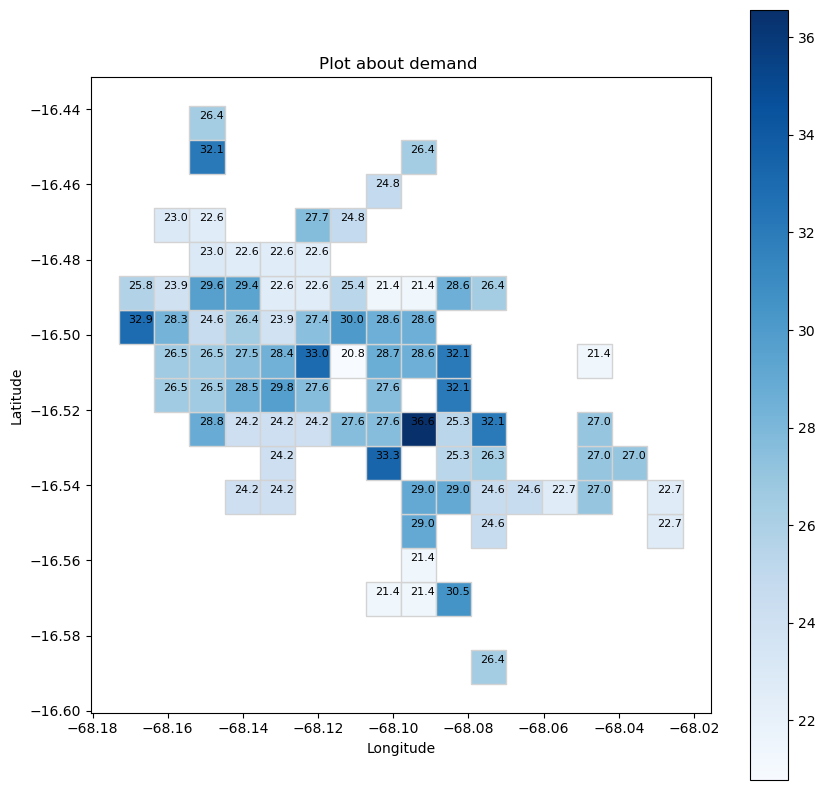

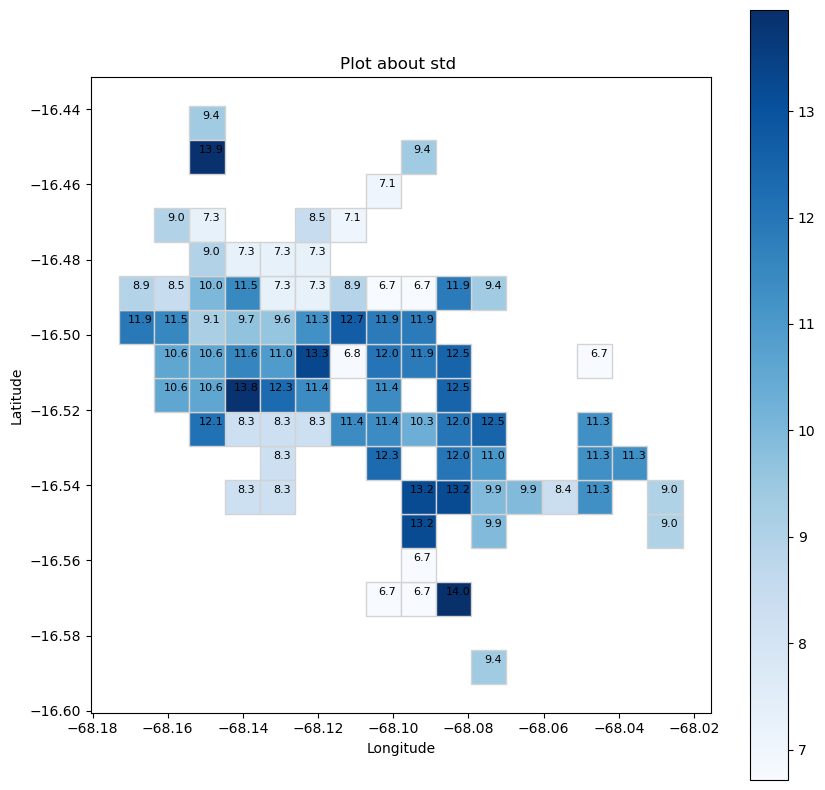

In [25]:
plot_meta_pixels(pixels.values(),
                meta_pixels,
                "demand")
plot_meta_pixels(pixels.values(),
                meta_pixels,
                "std")

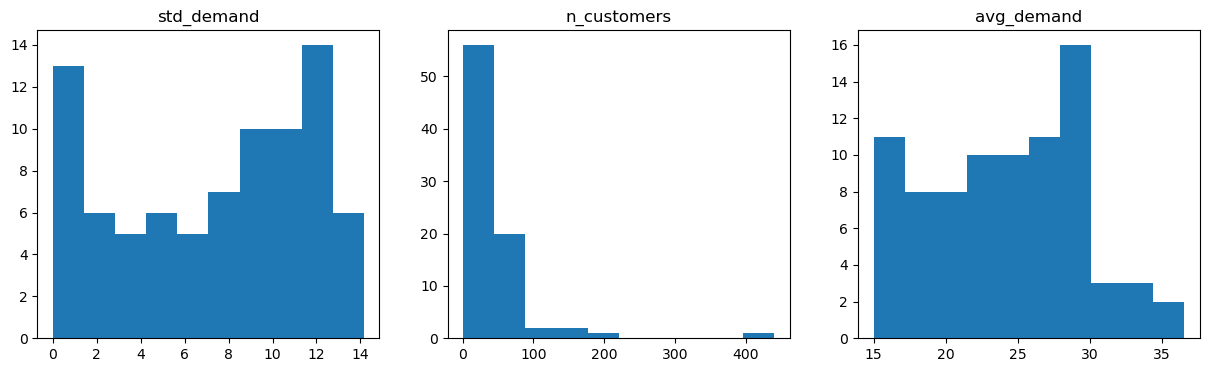

In [26]:
### HISTOGRAM
## just pixels
demand = []
std_ = []
n_ = []
for p in pixels.values():
    if p.get_n_customers() >0:
        demand.append(p.get_avg_demand())
        std_.append(p.get_std_demand())
        n_.append(p.get_n_customers())
    
data = {
        "avg_demand": demand,
        "std_demand": std_,
         "n": n_,
}
df = pd.DataFrame.from_dict(data)
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].hist(df['std_demand'], bins=10)
ax[0].set_title("std_demand")

ax[1].hist(df['n'], bins=10)
ax[1].set_title("n_customers")

ax[2].hist(df['avg_demand'], bins=10)
ax[2].set_title("avg_demand")

plt.show()

In [27]:
df.count()

avg_demand    82
std_demand    82
n             82
dtype: int64

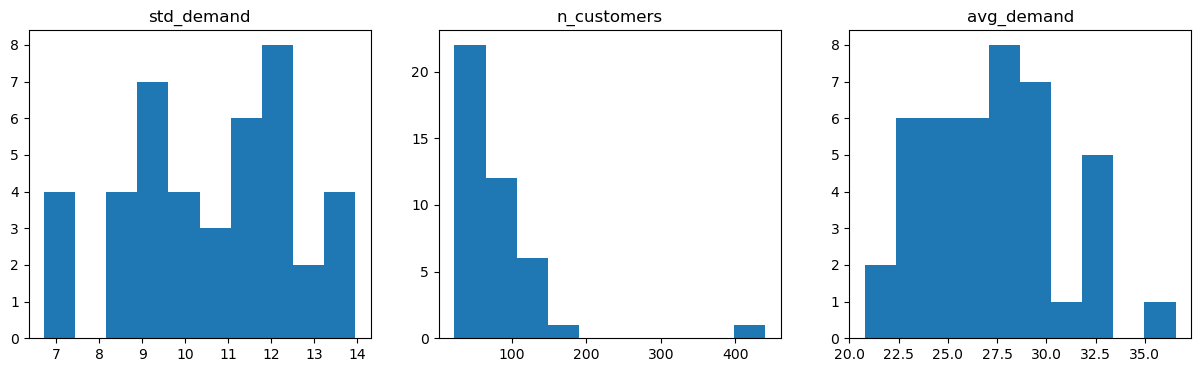

In [28]:
### HISTOGRAM
## just meta pixels
demand = []
std_ = []
n_ = []
for p in meta_pixels:
    if p.get_n_customers() > 0:
        demand.append(p.get_avg_demand())
        std_.append(p.get_std_demand())
        n_.append(p.get_n_customers())
    
data = {
        "avg_demand": demand,
        "std_demand": std_,
         "n": n_,
}
df = pd.DataFrame.from_dict(data)
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].hist(df['std_demand'], bins=10)
ax[0].set_title("std_demand")

ax[1].hist(df['n'], bins=10)
ax[1].set_title("n_customers")

ax[2].hist(df['avg_demand'], bins=10)
ax[2].set_title("avg_demand")

plt.show()

In [29]:
df.count()

avg_demand    42
std_demand    42
n             42
dtype: int64